Integrantes: 

- José Villar
- Pablo Oñate
- Catalina Montecinos



---



# **Importar librerias necesarias**

In [136]:
# Para la Data
import pandas as pd
import numpy as np

# Para la Visualización
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import missingno as msno
from wordcloud import WordCloud
import re 
import string
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image

# Para la construcción del modelo
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from tensorflow.keras.preprocessing.text import Tokenizer

# metricas
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss

# Para NLP
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')

# Para Styling
plt.style.use('fivethirtyeight')

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




---


# **Lectura del dataset y su distribución**


Lectura del *Train*

In [137]:
df = pd.read_csv('./Corona_NLP_train.csv',encoding='latin-1')
test = pd.read_csv('./Corona_NLP_test.csv',encoding="latin-1")
df['TweetAt'] = pd.to_datetime(df['TweetAt'])
df['Length'] = df['OriginalTweet'].apply(len)
train = df
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Length
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,237
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,131
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,306
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310


Lectura del Test

In [138]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Distribución de los datos

In [139]:
print(train.info(),'\n')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
 6   Length         41157 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.2+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   

Se muestran los valores faltantes por cada columna

Text(0.5, 1.0, 'Valores faltantes de cada columna')

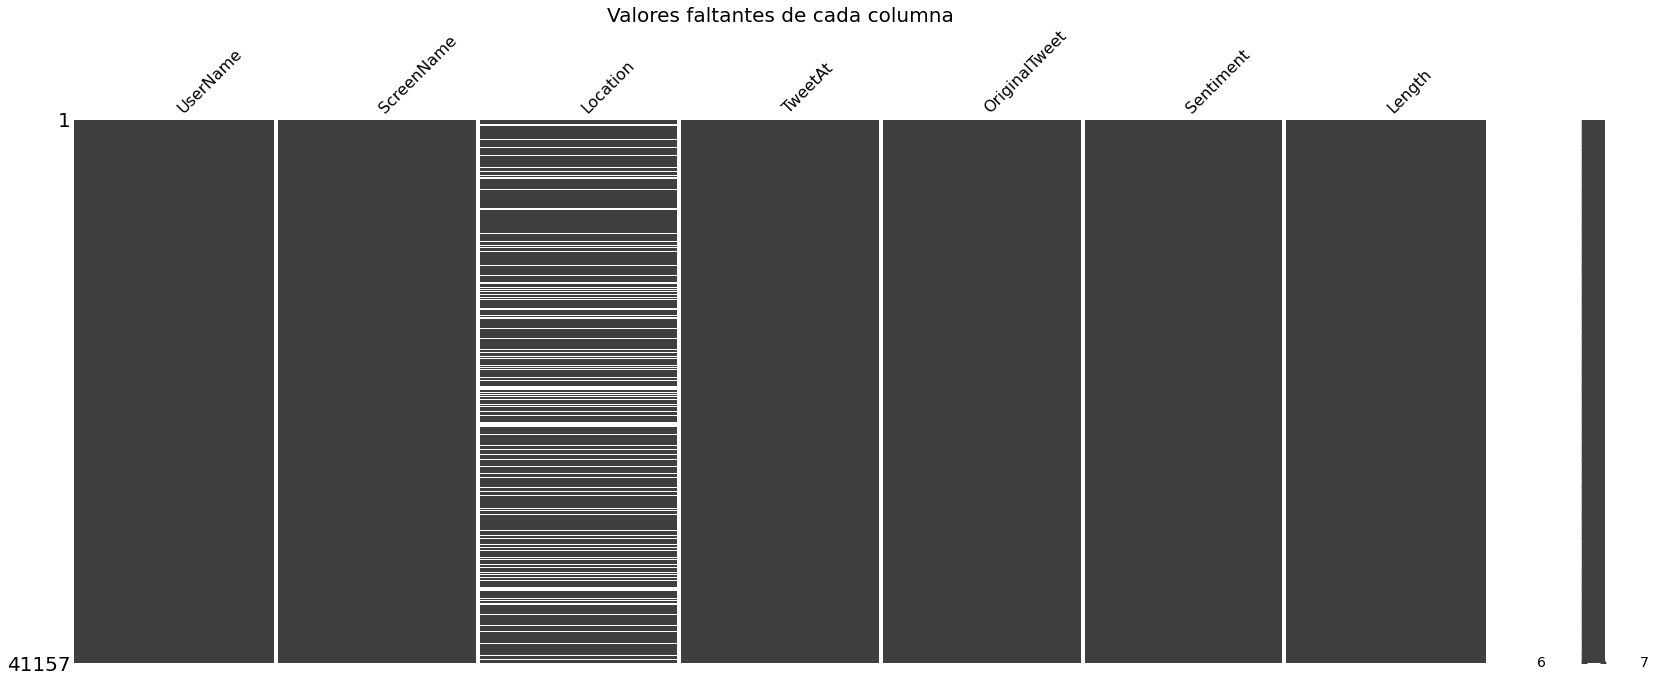

In [140]:
msno.matrix(df)
plt.title('Valores faltantes de cada columna',fontsize=20)

Ahora vamos a eliminar las entradas duplicadas.

In [141]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

Ahora vamos a eliminar las columnas UserName y ScreenName porque son para una identidad única y no afectarán nuestro modelo.

In [142]:
train.drop(['UserName', 'ScreenName'], axis=1, inplace=True)
test.drop(['UserName', 'ScreenName'], axis=1, inplace=True)

Volvemos a mostrar las columnas, para verificar que se borro y observar los valores faltantes.

Text(0.5, 1.0, 'Valores faltantes de cada columna')

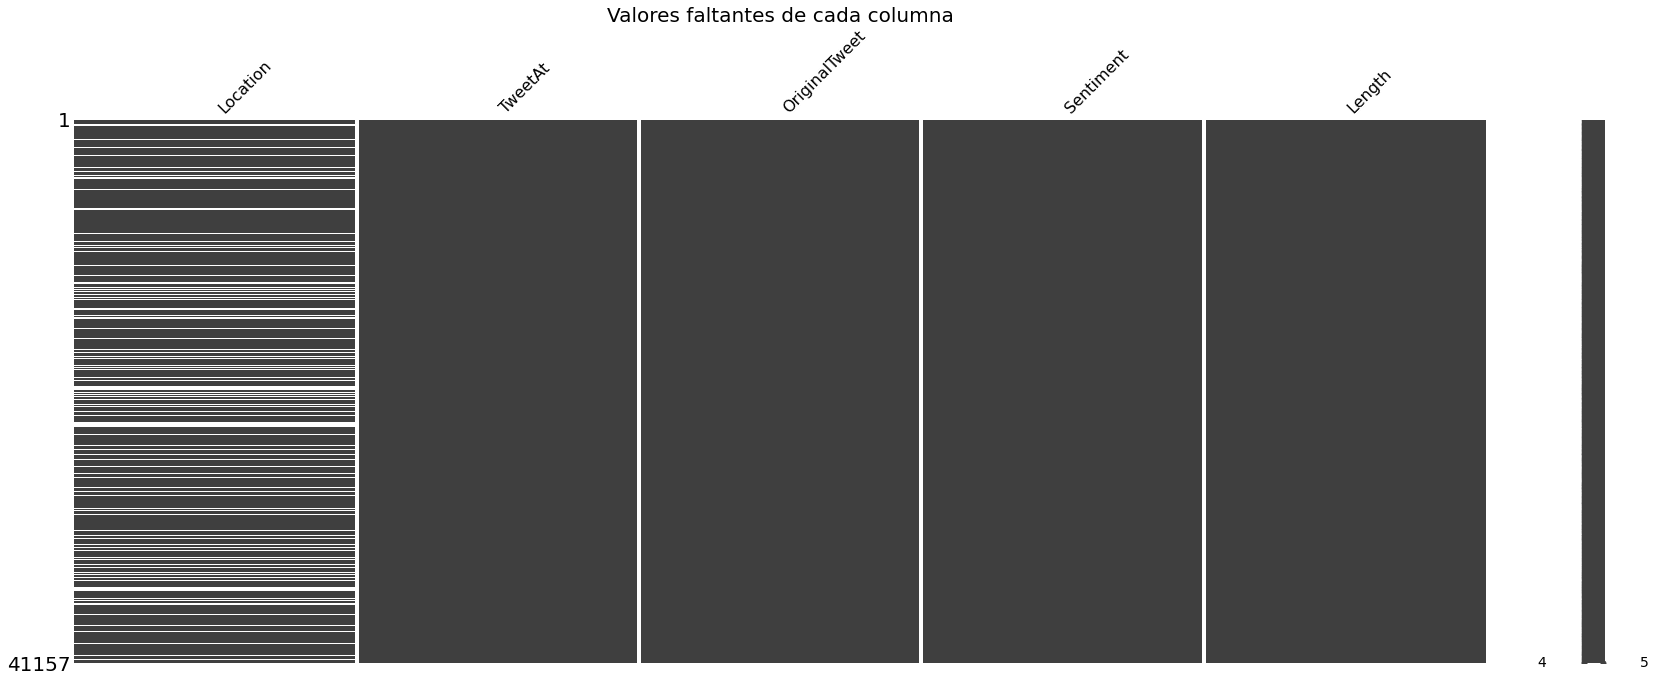

In [143]:
# Nuevamente mostramos las columnas con valores faltantes.
msno.matrix(train)
plt.title('Valores faltantes de cada columna',fontsize=20)

Comprobamos el número de valores perdidos

In [144]:
print(train.isnull().sum())

Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
Length              0
dtype: int64


Comprobamos la columna Location

In [145]:
print(train.Location.value_counts(normalize= True, dropna= False)[:30] *100)

NaN                        20.871298
London                      1.312049
United States               1.282892
London, England             1.263455
New York, NY                0.959740
Washington, DC              0.906286
United Kingdom              0.818816
Los Angeles, CA             0.682751
India                       0.651165
UK                          0.563695
Australia                   0.546687
USA                         0.541828
Canada                      0.464077
England, United Kingdom     0.464077
Toronto, Ontario            0.388755
Global                      0.386326
Chicago, IL                 0.376607
California, USA             0.371747
San Francisco, CA           0.369317
Boston, MA                  0.364458
New York, USA               0.340161
New Delhi, India            0.335301
Atlanta, GA                 0.306145
New York                    0.306145
Mumbai, India               0.264840
Worldwide                   0.245402
Lagos, Nigeria              0.240542
H



---


# **Análisis de las columnas del dataset por separado**

## *Columna TweetAt*

TweetAt representa la hora a la que se tuiteó.

Primero, veamos la distribución mensual de tweets:

Text(0.5, 1.0, 'Distribución mensual de tweets')

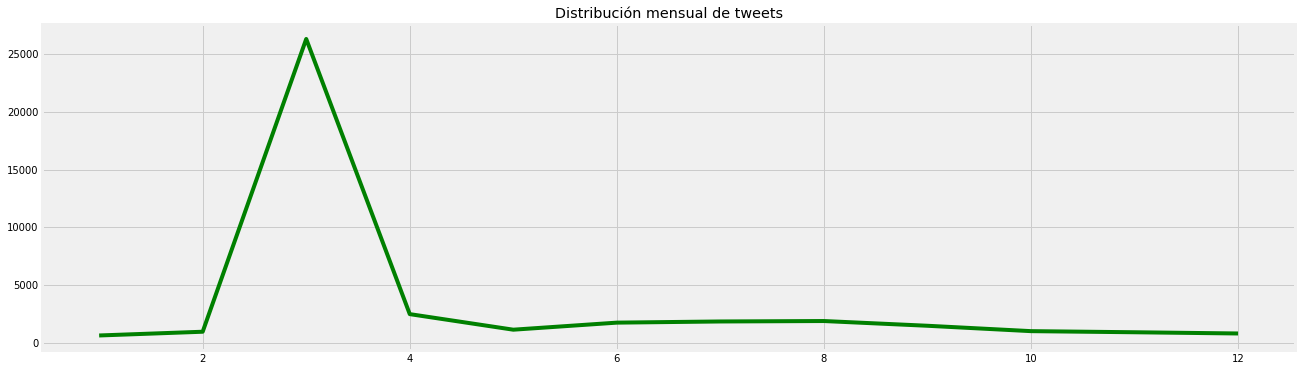

In [146]:
time = df.groupby(['TweetAt']).size()
monthly = df['TweetAt'].dt.month.value_counts().sort_index()
plt.figure(figsize=(20,6))
sns.lineplot(x=monthly.index, y = monthly.values, color='green')
plt.title('Distribución mensual de tweets')

Podemos notar que la fecha del conjunto de datos se distribuye principalmente en marzo;
Y debajo está la distribución de las fechas.

In [147]:
fig = px.line(df, x=time.index, y=time.values, title = 'Fecha de los tweets')
fig.show()

## **Columna Location**


Aquí exploraremos las 10 ubicaciones principales de tweets

In [148]:
location = df['Location'].value_counts()[:10]
fig = px.bar(x=location.index,y=location.values,text=location.values,
       color = location.index, color_discrete_sequence=px.colors.sequential.deep,
        title = 'Distribución del Top 10 de Localizaciones')
us,uk = [1,3,4,6],[0,2,5,8]

for idx in us:
    fig.data[idx].marker.line.width = 4
    fig.data[idx].marker.line.color = "crimson"
for idx in uk:
    fig.data[idx].marker.line.width = 4
    fig.data[idx].marker.line.color = "blue"
fig.show()

Podemos notar que el Reino Unido y los EE. UU. ocuparon los 2 primeros lugares de tweets de covid-19, y la India y Australia ocuparon el siguiente lugar.

## **Columna Sentiment**


Se observa la cantidad de datos por cada valor y su porcentaje.

In [149]:
print(train.Sentiment.value_counts(),'\n')
print(train.Sentiment.value_counts(normalize=True) * 100)

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64 

Positive              27.752266
Negative              24.095537
Neutral               18.740433
Extremely Positive    16.094468
Extremely Negative    13.317297
Name: Sentiment, dtype: float64



Se genera un grafico de pai para visualizar la distribución de los datos.



In [150]:
sentiment = df["Sentiment"].value_counts()
fig = px.pie(values=sentiment.values, 
             names=sentiment.index,
             color_discrete_sequence=px.colors.sequential.Greens)
fig.update_traces(textposition='inside',
                  textfont_size=11,
                  textinfo='percent+label')
fig.update_layout(title_text="Categoria grafico de Pie",
                  uniformtext_minsize=12, 
                  uniformtext_mode='hide')

fig.show()

Hay 5 sentimientos en el conjunto de datos: Positivo, Negativo, Neutral, Extremadamente Positivo y Extremadamente Negativo.
Cada Positivo y Negativo representan el 27,8% y el 24,1%

Se Compara la longitud del tweet de cada sentimiento.

In [151]:
positive = df.loc[np.where(df['Sentiment'] == 'Positive')].reset_index()
negative = df.loc[np.where(df['Sentiment'] == 'Negative')].reset_index()
neutral = df.loc[np.where(df['Sentiment'] == 'Neutral')].reset_index()
extremely_positive = df.loc[np.where(df['Sentiment'] == 'Extremely Positive')].reset_index()
extremely_negative = df.loc[np.where(df['Sentiment'] == 'Extremely Negative')].reset_index()
hist_data = [extremely_positive['Length'],positive['Length'],neutral['Length'],
             negative['Length'],extremely_negative['Length']]

group_labels = ['extremely_positive','positive','neutral','negative','extremely_negative']

colors = ['navy', 'blue', 'lightblue','lightsalmon','red']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors = colors)

# Add title
fig.update_layout(title_text='Distribución de longitud de cada sentimiento')
fig.show()

El sentimiento de 'extremadamente negativo' y 'extremadamente positivo' se distribuyó mayoritariamente en gran parte, y negativo y positivo el siguiente.



---


# **Análisis del dataset en correlación de las columnas**

Revisaremos los lugares alrededor del mundo que tuitearon más sobre COVID y el estado de ánimo de estos.

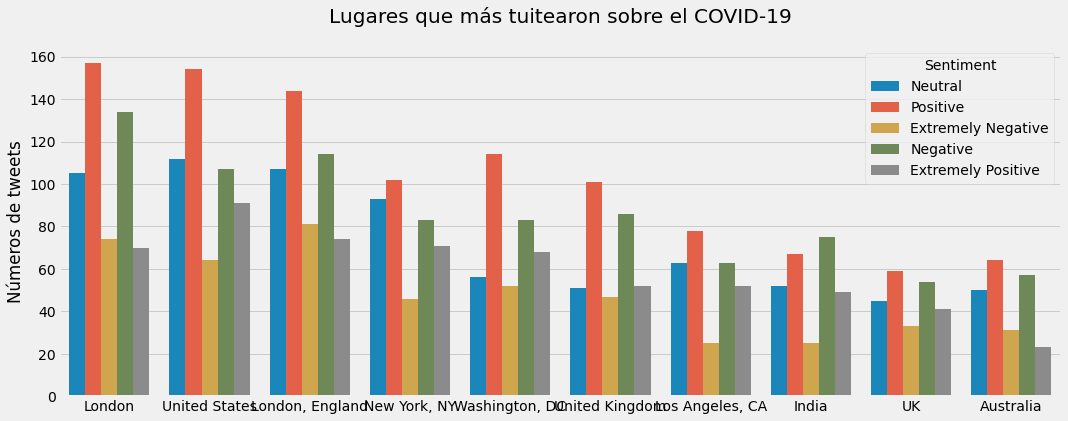

In [152]:
# gráfico de las principales ciudades/países
plt.style.use("fivethirtyeight")

plt.figure(figsize=(16, 6))
location = sns.countplot(x= 'Location', data= train, hue="Sentiment", order=train.Location.value_counts()[:10].index)
location.set_title("Lugares que más tuitearon sobre el COVID-19", y=1.05)

def axis_labels(ax):
    ax.set_ylabel("Números de tweets")
    ax.set_xlabel("")

axis_labels(location)

plt.show()

Londres y Nueva York lideran el camino en términos de ciudades que más tuitearon sobre covid19

También observamos un patrón: hay más tuits positivos que negativos en todas las ciudades/países si combinamos datos de tuits positivos y extremadamente positivos.

TweetAt, que contiene las horas en que se realizaron los tweets, tiene un tipo de datos de objeto; lo convertiremos en un tipo de datos de fecha y hora.

In [153]:
# Convertir la columna TweetAt a fecha y hora 
train['TweetAt'] = pd.to_datetime(train['TweetAt'])

# crear columnas de día de la semana y mes
train['day'] = train['TweetAt'].dt.dayofweek
train['month'] = train['TweetAt'].dt.month

days = {0: 'Monday', 1: 'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
months = {1: 'January ', 2: 'February', 3:'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July',
      8:'August', 9:'September', 10: 'October', 11: 'November', 12: 'December'  }

train["day"] = train["day"].map(days)
train["month"] = train["month"].map(months)

In [154]:
print(f"Primer tweet: {train['TweetAt'].dt.date.min()}, Último tweet: {train['TweetAt'].dt.date.max()}")

Primer tweet: 2020-01-04, Último tweet: 2020-12-04


Nuestros datos de tweets, que contienen tweets relacionados con covid realizados solo en 2020, se recopilaron durante un período de 11 meses (del 4 de enero de 2020 al 4 de diciembre de 2020)

Creamos un gráfico que nos muestra el número de tuits realizados según el día de la semana.

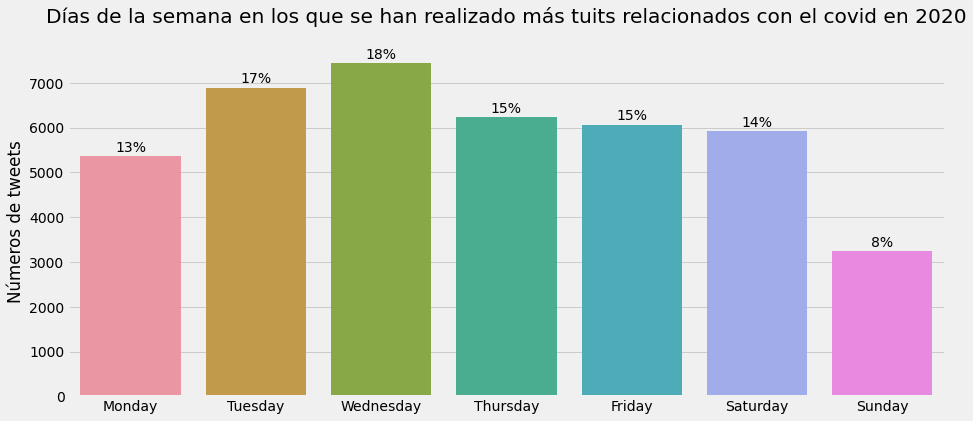

In [155]:
plt.figure(figsize=(14, 6))
days = sns.countplot(x="day", data=train)
days.set_title("Días de la semana en los que se han realizado más tuits relacionados con el covid en 2020", 
                                             y=1.05)

def add_labels(ax, space):
    for rect in ax.patches:
        width = rect.get_width()
        height = rect.get_height()
        total = train.shape[0]
        
        ax.text(rect.get_x() + width/2,
               height + space,
               '{}%'.format(int(np.round(height/total*100))),
                ha="center")

add_labels(days, 100)
axis_labels(days)
plt.show()

Se observa el porcentaje de tuits realizados entre Enero y Diciembre.

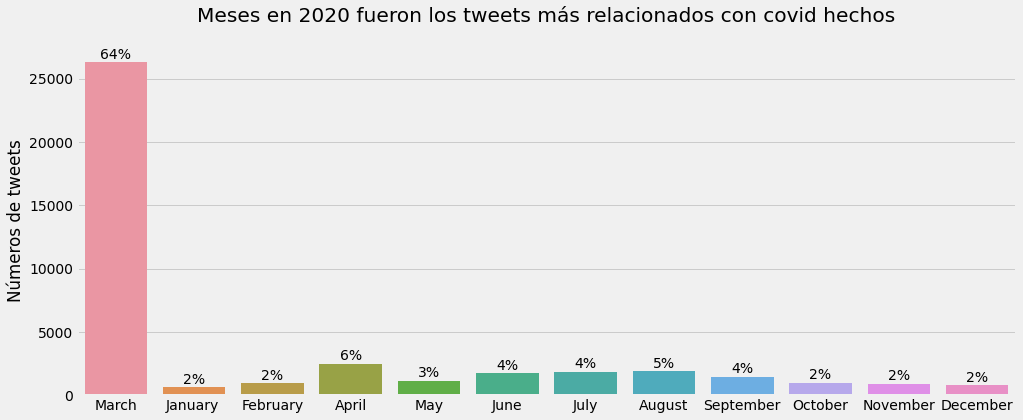

In [156]:
plt.figure(figsize=(15, 6))
months = sns.countplot(train['month'])
months.set_title("Meses en 2020 fueron los tweets más relacionados con covid hechos", 
                                             y=1.05)

add_labels(months, 300)
axis_labels(months)
plt.show()



---


# **Preprocesamiento del texto**

Se imprimen los tuits con el texto original

In [157]:
def tweets(df, n, col_name="OriginalTweet"):
    for tweet_no, tweet in enumerate(df[col_name][:n]):
        print(tweet_no+1, tweet, '\n')
        print("*" * 60, '\n')
        
tweets(train, 10)

1 @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8 

************************************************************ 

2 advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order 

************************************************************ 

3 Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P 

************************************************************ 






#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j 

************************************************************ 





#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n 

************************************

Se realiza una limpieza a los textos de los tuits.

In [158]:
# combine train and test dataframes
combined = pd.concat([train, test], ignore_index= True)

# select relevant features: tweet and Sentiments
combined = combined.loc[:, ["OriginalTweet", "Sentiment"]]

# load stop words
stop_word = stopwords.words('english')

def clean_tweet(text):
    text = re.sub(r"#\w+", " ", text)            # remove hashtags
    text = re.sub(r"@\w+", " ",text)             # remove mentions
    text = re.sub(r"http\S+", " ", text)         # remove urls
    text = re.sub(r"[^a-zA-Z]", " ", text)       # remove non-words (digits, punctuations etc)
    text = text.lower().strip()                  # convert tweet to lowercase and strip
    
    text = " ".join([word for word in text.split() if not word in stop_word])           # remove stop words    
    
    text = " ".join(nltk.word_tokenize(text))           # tokenize text
      
    return text

# clean OriginalTweet and assign the data to an new "tweet" column
combined['tweet'] = combined['OriginalTweet'].apply(lambda x: clean_tweet(x))

Se muestran los tuits después del preprocesamiento.

In [159]:
tweets(combined, 8, "tweet")

1  

************************************************************ 

2 advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order 

************************************************************ 

3 coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak 

************************************************************ 

4 food stock one empty please panic enough food everyone take need stay calm stay safe 

************************************************************ 

5 ready go supermarket outbreak paranoid food stock litteraly empty serious thing please panic causes shortage 

************************************************************ 

6 news region first confirmed covid case came sullivan county last week people flocked area stores purchase cleaning supplies hand sanitizer food toilet paper goods reports 



---


# **Visualización de las palabras**

Visualización de nube de palabras de los hashtags más utilizados

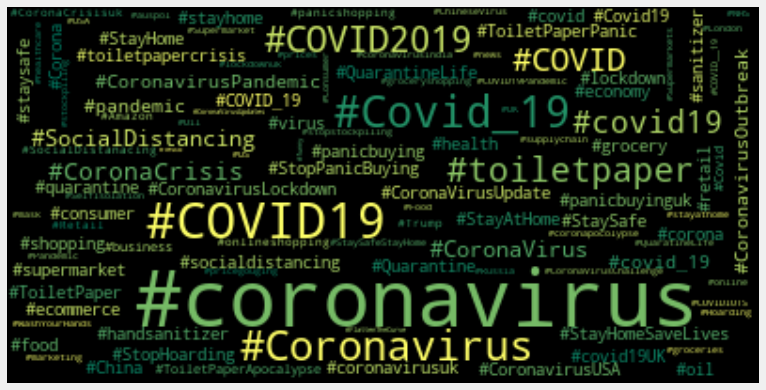

In [160]:
def create_wordCloud(pattern):
    """crear visualización de nube de palabras
    
    argumentos:
        patrón (str): patrón de expresiones regulares para extraer cierto texto de los datos
    """
    data = train["OriginalTweet"].str.extractall(pattern)[0].value_counts()

    data.index = data.index.map(str)                                                       # convertir índice de datos a cadena
    data_wc = WordCloud(max_words = 500, colormap='summer', 
                        background_color='black').generate_from_frequencies(data)          # generar nube de palabras

    
    # mostrar la nube
    fig = plt.figure()
    fig.set_figwidth(12) # establecer ancho
    fig.set_figheight(12) # establecer alto

    plt.imshow(data_wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
# crear una nube de palabras de los hashtags más utilizados
hashtag = r"(#\w+)"
create_wordCloud(hashtag)

Visualización de nube de palabras más utilizados

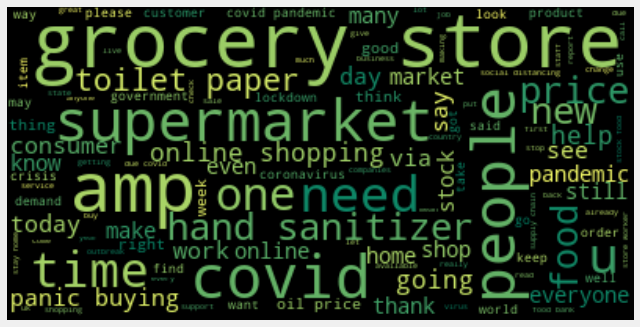

In [161]:
# palabras más comunes en el datataset de tweet
corpus = ",".join(word for word in combined.tweet)
stopwords = set(STOPWORDS)
tweet_wc = WordCloud(max_words = 500, colormap='summer', 
                        background_color='black', stopwords=stopwords).generate(corpus)   

# mostrar la nube
fig = plt.figure()
fig.set_figwidth(10) # establecer ancho
fig.set_figheight(10) # establecer alto

plt.imshow(tweet_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# **CLASIFICACIÓN**

In [162]:
#Funcion para metricas de clasificacion

#Metricas

def metricas(clases_reales, clases_predichas):
    """ Calcular las métricas utilizando sklearn """
    matriz = confusion_matrix(clases_reales, clases_predichas)
    accuracy = accuracy_score(clases_reales, clases_predichas)
    precision = precision_score(clases_reales, clases_predichas,average="macro")
    recall = recall_score(clases_reales, clases_predichas,average="macro")
    f1_macro = f1_score(clases_reales, clases_predichas,average="macro")
    f1_micro = f1_score(clases_reales, clases_predichas,average="micro")
    hamming = hamming_loss(clases_reales, clases_predichas)
    return matriz, accuracy, precision, recall, f1_macro, f1_micro,hamming

In [163]:
# Se le hace encode a las etiquetas
le = LabelEncoder()
combined.Sentiment = le.fit_transform(combined.Sentiment)

# Dividir en conjunto de entramiento y validación
train = combined[: len(train)]
test = combined[len(train):].reset_index(drop=True)

# Dividir el conjunto de validación
X_test = test.tweet
y_test = test.Sentiment



# split training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(train.tweet,train.Sentiment, test_size=0.2,random_state=42)

print(f'X_train: \n {X_train} \n \n Y_train: \n{y_train}')
print(f'****'.center(50, '-'))
print(f'\nX_test: \n{X_test} \n\nY_test: \n{y_test}')

X_train: 
 8191     unemployment claims made online virginia week ...
3725     panic buying response could damaging effect ag...
22759    e cigarette users tobacco smokers danger new c...
15010    know youtube prankster going video go supermar...
39142    appetite meat change also need change activiti...
                               ...                        
6265     minnesota classifies grocery store workers eme...
11284    us senator asked information price fallen mont...
38158    commented poll online shopping normal covid cr...
860      wife got laid yesterday small retail store wor...
15795                                      humanity doomed
Name: tweet, Length: 32925, dtype: object 
 
 Y_train: 
8191     2
3725     0
22759    2
15010    3
39142    0
        ..
6265     2
11284    2
38158    0
860      3
15795    0
Name: Sentiment, Length: 32925, dtype: int64
-----------------------****-----------------------

X_test: 
0       trending new yorkers encounter empty supermark...

In [164]:
# inicializamos la vectorización
cv = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=5)
vectorizer = cv.fit(X_train)

X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [165]:
array_x_train = X_train.toarray()
output_x_train = pd.DataFrame(data = array_x_train, columns = cv.get_feature_names())
output_x_train

,aaron,ab,abandoned,abc,abide,ability,able,able buy,able food,able help,...,yrs,yummy,zealand,zero,zimbabwe,zombie,zombie apocalypse,zombies,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Regresión Logísitca**

In [166]:
# inicialice el modelo y hacemos el fit en los datos de entrenamiento
logmodel = LogisticRegression(max_iter=10000)
logmodel.fit(X_train, y_train)

# Vemos la accuracy del entrenamiento
cross_val_score(logmodel, X_train, y_train, cv=5, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.9s finished


0.5931662870159453

In [167]:
# extraemos las etiquetas del encoder
labels = list(le.classes_)

In [168]:
# predicciones
val_pred = logmodel.predict(X_val)
test_pred = logmodel.predict(X_test)

# classification report
print(classification_report(val_pred, y_val, target_names= labels), '\n')
print(classification_report(test_pred, y_test, target_names= labels))

                    precision    recall  f1-score   support

Extremely Negative       0.58      0.65      0.61       936
Extremely Positive       0.62      0.69      0.65      1185
          Negative       0.53      0.54      0.54      1973
           Neutral       0.75      0.65      0.70      1784
          Positive       0.59      0.58      0.59      2354

          accuracy                           0.61      8232
         macro avg       0.61      0.62      0.62      8232
      weighted avg       0.61      0.61      0.61      8232
 

                    precision    recall  f1-score   support

Extremely Negative       0.54      0.63      0.58       509
Extremely Positive       0.57      0.66      0.61       515
          Negative       0.49      0.51      0.50      1009
           Neutral       0.68      0.60      0.64       696
          Positive       0.58      0.51      0.54      1069

          accuracy                           0.56      3798
         macro avg       0.57    

In [170]:
# Conjunto de Validación
print("Conjunto de Validacion")
print("")
met = metricas(y_val,val_pred)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

print("")

#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,test_pred)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Validacion

Matriz
[[ 608   15  374   33   26]
 [   9  818   38   26  439]
 [ 250   54 1067  292  343]
 [  15   20  167 1163  188]
 [  54  278  327  270 1358]]
Accuracy:  0.609086491739553
Precision:  0.6218930096173905
Recall:  0.6130727196384339
F1_macro 0.615901281687446
F1_micro 0.609086491739553
Hamming Loss: 0.390913508260447

Conjunto de Test

Matriz
[[322   4 210  22  34]
 [  8 340  33   8 210]
 [149  30 515 149 198]
 [  2  11 104 421  81]
 [ 28 130 147  96 546]]
Accuracy:  0.564507635597683
Precision:  0.5837712518472971
Recall:  0.5725870032474172
F1_macro 0.5759491194829311
F1_micro 0.564507635597683
Hamming Loss: 0.43549236440231703


### **Naive Bayes**

In [171]:
from sklearn import naive_bayes
model=naive_bayes.MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [172]:
predNB=model.predict(X_test)

In [173]:
print(classification_report(y_test,predNB,target_names= labels))

                    precision    recall  f1-score   support

Extremely Negative       0.48      0.52      0.50       592
Extremely Positive       0.58      0.48      0.52       599
          Negative       0.44      0.41      0.42      1041
           Neutral       0.52      0.48      0.50       619
          Positive       0.40      0.48      0.44       947

          accuracy                           0.46      3798
         macro avg       0.48      0.47      0.48      3798
      weighted avg       0.47      0.46      0.47      3798



In [174]:
#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,predNB)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Test

Matriz
[[307   6 202  24  53]
 [ 24 285  53  13 224]
 [213  27 422 130 249]
 [ 25  24 127 298 145]
 [ 75 146 165 108 453]]
Accuracy:  0.4647182727751448
Precision:  0.4838639406065216
Recall:  0.4719055705542507
F1_macro 0.47570261954781967
F1_micro 0.4647182727751448
Hamming Loss: 0.5352817272248552


### **Random Forest**

In [175]:
from sklearn.ensemble import RandomForestClassifier
RFC=RandomForestClassifier(random_state=0)
RFC.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [176]:
predrfc=RFC.predict(X_test)

In [177]:
print(classification_report(y_test,predrfc,target_names= labels))

                    precision    recall  f1-score   support

Extremely Negative       0.62      0.34      0.44       592
Extremely Positive       0.63      0.35      0.45       599
          Negative       0.49      0.50      0.49      1041
           Neutral       0.55      0.76      0.64       619
          Positive       0.47      0.59      0.52       947

          accuracy                           0.52      3798
         macro avg       0.55      0.51      0.51      3798
      weighted avg       0.54      0.52      0.51      3798



In [178]:
#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,predrfc)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Test

Matriz
[[203   8 278  40  63]
 [ 15 211  44  20 309]
 [ 78  35 522 191 215]
 [  2   4  87 472  54]
 [ 27  76 139 143 562]]
Accuracy:  0.5186940494997367
Precision:  0.5512804881334836
Recall:  0.5105146574441607
F1_macro 0.5096171528509089
F1_micro 0.5186940494997367
Hamming Loss: 0.4813059505002633


### **Decision Tree**

In [179]:
from sklearn.tree import DecisionTreeClassifier
DTC=DecisionTreeClassifier(random_state=0)
DTC.fit(X_train,y_train)

DecisionTreeClassifier(random_state=0)

In [180]:
preddtc=DTC.predict(X_test)


In [181]:
print(classification_report(y_test,preddtc,target_names= labels))

                    precision    recall  f1-score   support

Extremely Negative       0.45      0.41      0.43       592
Extremely Positive       0.50      0.47      0.48       599
          Negative       0.43      0.39      0.41      1041
           Neutral       0.54      0.65      0.59       619
          Positive       0.41      0.44      0.42       947

          accuracy                           0.46      3798
         macro avg       0.47      0.47      0.47      3798
      weighted avg       0.46      0.46      0.46      3798



In [182]:
#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,preddtc)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Test

Matriz
[[242  29 201  46  74]
 [ 25 280  58  28 208]
 [185  74 409 142 231]
 [ 22  16  91 400  90]
 [ 60 164 186 120 417]]
Accuracy:  0.4602422327540811
Precision:  0.4671250490566785
Recall:  0.4711324881046834
F1_macro 0.4676105744333981
F1_micro 0.4602422327540811
Hamming Loss: 0.539757767245919


## KNN

In [187]:
from sklearn.neighbors import KNeighborsClassifier #KNN

class_ = KNeighborsClassifier()
class_.fit(X_train, y_train)

knnp = class_.predict(X_test)

print(classification_report(y_test,knnp,target_names= labels))

                    precision    recall  f1-score   support

Extremely Negative       0.57      0.04      0.08       592
Extremely Positive       0.86      0.04      0.08       599
          Negative       0.36      0.16      0.22      1041
           Neutral       0.19      0.95      0.31       619
          Positive       0.36      0.06      0.10       947

          accuracy                           0.23      3798
         macro avg       0.47      0.25      0.16      3798
      weighted avg       0.44      0.23      0.16      3798



In [188]:
#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,knnp)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Test

Matriz
[[ 26   1 155 403   7]
 [  5  24  38 472  60]
 [ 10   1 165 843  22]
 [  2   0  21 585  11]
 [  3   2  79 807  56]]
Accuracy:  0.22538177988414956
Precision:  0.4659399020091727
Recall:  0.24933878868255466
F1_macro 0.15870095623630093
F1_micro 0.22538177988414956
Hamming Loss: 0.7746182201158505


## Multi-layer Perceptron

In [183]:
from sklearn.neural_network import MLPClassifier #MLP

class_ = MLPClassifier(random_state=1, max_iter=100)

class_.fit(X_train, y_train)

MLPClassifier(max_iter=100, random_state=1)

In [184]:
mlpp = class_.predict(X_test)

In [185]:
print(classification_report(y_test,mlpp,target_names= labels))

                    precision    recall  f1-score   support

Extremely Negative       0.60      0.56      0.58       592
Extremely Positive       0.63      0.56      0.59       599
          Negative       0.49      0.48      0.49      1041
           Neutral       0.58      0.63      0.61       619
          Positive       0.50      0.54      0.52       947

          accuracy                           0.54      3798
         macro avg       0.56      0.55      0.55      3798
      weighted avg       0.55      0.54      0.54      3798



In [186]:
#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,mlpp)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Test

Matriz
[[329   3 205  21  34]
 [  6 333  34  13 213]
 [180  37 501 138 185]
 [  5  13 130 391  80]
 [ 32 146 153 106 510]]
Accuracy:  0.5434439178515008
Precision:  0.5590332697488438
Recall:  0.5526289079588694
F1_macro 0.5549343343238636
F1_micro 0.5434439178515008
Hamming Loss: 0.4565560821484992


# Los datos se cambian desde 5 clases a 3.

Las clases que quedan son:

- Negativas: Extremadamente Negativas, Negativas.
- Neutral: Neutral.
- Positivo: Extremadamente Positivas, Positivas.

In [189]:
# Dividir en conjunto de entramiento y validación
train["Sentiment"] = train["Sentiment"].replace(0,6)
train["Sentiment"] = train["Sentiment"].replace(2,6)
train["Sentiment"] = train["Sentiment"].replace(3,7)
train["Sentiment"] = train["Sentiment"].replace(1,8)
train["Sentiment"] = train["Sentiment"].replace(4,8)

test["Sentiment"] = train["Sentiment"].replace(0,6)
test["Sentiment"] = train["Sentiment"].replace(2,6)
test["Sentiment"] = train["Sentiment"].replace(3,7)
test["Sentiment"] = train["Sentiment"].replace(1,8)
test["Sentiment"] = train["Sentiment"].replace(4,8)

# Dividir el conjunto de validación
X_test = test.tweet
y_test = test.Sentiment

# split training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(train.tweet,train.Sentiment, test_size=0.2,random_state=42)

# inicializamos la vectorización
cv = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=5)
vectorizer = cv.fit(X_train)

X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

## Regresion Logistica

In [190]:
# inicialice el modelo y hacemos el fit en los datos de entrenamiento
logmodel = LogisticRegression(max_iter=10000)
logmodel.fit(X_train, y_train)

# Vemos la accuracy del entrenamiento
cross_val_score(logmodel, X_train, y_train, cv=5, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.7s finished


0.7938344722854973

In [193]:
# predicciones
val_pred = logmodel.predict(X_val)
test_pred = logmodel.predict(X_test)

# extraemos las etiquetas del encoder
labels = ["Negativo","Neutral","Positivo"]

# classification report
print(classification_report(val_pred, y_val, target_names= labels), '\n')
print(classification_report(test_pred, y_test, target_names= labels))

              precision    recall  f1-score   support

    Negativo       0.79      0.82      0.80      2949
     Neutral       0.75      0.70      0.72      1677
    Positivo       0.84      0.84      0.84      3606

    accuracy                           0.80      8232
   macro avg       0.79      0.78      0.79      8232
weighted avg       0.80      0.80      0.80      8232
 

              precision    recall  f1-score   support

    Negativo       0.41      0.41      0.41      1542
     Neutral       0.17      0.17      0.17       648
    Positivo       0.42      0.41      0.42      1608

    accuracy                           0.37      3798
   macro avg       0.33      0.33      0.33      3798
weighted avg       0.37      0.37      0.37      3798



In [194]:
# Conjunto de Validación
print("Conjunto de Validacion")
print("")
met = metricas(y_val,val_pred)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

print("")

#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,test_pred)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Validacion

Matriz
[[2409  271  382]
 [ 196 1167  190]
 [ 344  239 3034]]
Accuracy:  0.8029640427599611
Precision:  0.7847160251691659
Recall:  0.7923354000123127
F1_macro 0.7880750967563807
F1_micro 0.8029640427599611
Hamming Loss: 0.19703595724003886

Conjunto de Test

Matriz
[[631 277 646]
 [249 112 298]
 [662 259 664]]
Accuracy:  0.3704581358609795
Precision:  0.3316612164235268
Recall:  0.33164360910779106
F1_macro 0.33163913083828206
F1_micro 0.37045813586097953
Hamming Loss: 0.6295418641390206


## Naive Bayes

In [195]:
model=naive_bayes.MultinomialNB()
model.fit(X_train, y_train)
predNB=model.predict(X_test)
print(classification_report(y_test,predNB,target_names= labels))

              precision    recall  f1-score   support

    Negativo       0.40      0.44      0.42      1554
     Neutral       0.18      0.14      0.15       659
    Positivo       0.41      0.41      0.41      1585

    accuracy                           0.37      3798
   macro avg       0.33      0.33      0.33      3798
weighted avg       0.36      0.37      0.37      3798



In [196]:
#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,predNB)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Test

Matriz
[[689 226 639]
 [277  89 293]
 [759 184 642]]
Accuracy:  0.37388098999473407
Precision:  0.32855167369033283
Recall:  0.3278241242526102
F1_macro 0.32680703827494967
F1_micro 0.37388098999473407
Hamming Loss: 0.6261190100052659


## Random Forest

In [197]:
RFC=RandomForestClassifier(random_state=0)
RFC.fit(X_train,y_train)
predrfc=RFC.predict(X_test)
print(classification_report(y_test,predrfc,target_names= labels))

              precision    recall  f1-score   support

    Negativo       0.41      0.41      0.41      1554
     Neutral       0.17      0.18      0.18       659
    Positivo       0.42      0.41      0.41      1585

    accuracy                           0.37      3798
   macro avg       0.33      0.33      0.33      3798
weighted avg       0.37      0.37      0.37      3798



In [198]:
#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,predrfc)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Test

Matriz
[[636 283 635]
 [260 119 280]
 [657 278 650]]
Accuracy:  0.3699315429173249
Precision:  0.3332884684354786
Recall:  0.333312559249956
F1_macro 0.33328037715249803
F1_micro 0.3699315429173249
Hamming Loss: 0.6300684570826751


## Decision Tree

In [199]:
DTC=DecisionTreeClassifier(random_state=0)
DTC.fit(X_train,y_train)
preddtc=DTC.predict(X_test)
print(classification_report(y_test,preddtc,target_names= labels))

              precision    recall  f1-score   support

    Negativo       0.40      0.39      0.40      1554
     Neutral       0.18      0.19      0.18       659
    Positivo       0.41      0.41      0.41      1585

    accuracy                           0.37      3798
   macro avg       0.33      0.33      0.33      3798
weighted avg       0.37      0.37      0.37      3798



In [200]:
#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,preddtc)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Test

Matriz
[[610 283 661]
 [257 124 278]
 [647 283 655]]
Accuracy:  0.3657187993680885
Precision:  0.33117742946716494
Recall:  0.3313161628552025
F1_macro 0.3311907819559156
F1_micro 0.3657187993680885
Hamming Loss: 0.6342812006319115


## KNN

In [201]:
class_ = KNeighborsClassifier()
class_.fit(X_train, y_train)

knnp = class_.predict(X_test)

print(classification_report(y_test,knnp,target_names= labels))

              precision    recall  f1-score   support

    Negativo       0.42      0.14      0.21      1554
     Neutral       0.18      0.83      0.29       659
    Positivo       0.43      0.05      0.10      1585

    accuracy                           0.23      3798
   macro avg       0.34      0.34      0.20      3798
weighted avg       0.38      0.23      0.18      3798



In [202]:
#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,knnp)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Test

Matriz
[[ 223 1253   78]
 [  76  548   35]
 [ 236 1262   87]]
Accuracy:  0.2259083728278041
Precision:  0.34357733189724
Recall:  0.3433177358697816
F1_macro 0.20181453825470905
F1_micro 0.2259083728278041
Hamming Loss: 0.7740916271721959


## Multi-Layer Perception

In [203]:
class_ = MLPClassifier(random_state=1, max_iter=100)

class_.fit(X_train, y_train)
mlpp = class_.predict(X_test)
print(classification_report(y_test,mlpp,target_names= labels))

              precision    recall  f1-score   support

    Negativo       0.40      0.40      0.40      1554
     Neutral       0.17      0.16      0.17       659
    Positivo       0.40      0.41      0.41      1585

    accuracy                           0.36      3798
   macro avg       0.33      0.33      0.33      3798
weighted avg       0.36      0.36      0.36      3798



In [204]:
#Conjunto de Test
print("Conjunto de Test")
print("")
met = metricas(y_test,mlpp)

print("Matriz")
print(met[0])

print("Accuracy: ",met[1])
print("Precision: ",met[2])
print("Recall: ", met[3])
print("F1_macro", met[4])
print("F1_micro",met[5])
print("Hamming Loss:",met[6])

Conjunto de Test

Matriz
[[621 268 665]
 [250 108 301]
 [680 250 655]]
Accuracy:  0.3644023170089521
Precision:  0.3256607898738865
Recall:  0.32558259490615654
F1_macro 0.3255674145348419
F1_micro 0.3644023170089521
Hamming Loss: 0.6355976829910479
